<a href="https://colab.research.google.com/github/MatSci495/Lectures/blob/main/OnePeakOrTwo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example 1 — Is a broadened feature one peak or two?

**Guiding question.**\
When a spectrum shows a broadened feature or a faint shoulder, how do we decide if the data truly support **two overlapping peaks** rather than a single broadened peak? Visual plausibility is not enough; the decision should be grounded in whether the two-peak model removes **systematic residual structure** beyond what noise justifies, and whether the extra parameters are warranted statistically and physically.

**Learning goals.**\
By the end, you will (i) fit single- and double-peak models to 1D spectral data, (ii) evaluate **residual structure** as the primary indicator of model adequacy, (iii) compare **nested models** via the likelihood-ratio statistic $$\Delta\chi^2$$ when the noise model is specified, (iv) apply **AIC** to penalize unnecessary complexity, and (v) interpret results in terms of plausible physics (domains, phases, strain, composition).

**Physics context.**\
Peak “splitting” can indicate domain coexistence, structural phase mixtures, compositional heterogeneity, or strain distributions. Yet baseline choices, limited resolution, and random noise often mimic shoulders. We will use **residual literacy** and **model comparison** to avoid over-interpreting suggestive shapes.

## Synthetic data setup (with realistic heteroskedastic noise)

We simulate two partially overlapping Voigt peaks with a shared width to represent two physical contributions. To mimic CCD/photon statistics and readout, we add **heteroskedastic** noise with standard deviation
$$
\sigma_i \;=\; \sqrt{\,\sigma_0^2 \;+\; (\alpha\,y_i)^2\,}\,,
$$
where $y_i$ is the noise-free intensity, $\alpha$ is a fractional noise level (e.g., 0.05–0.10), and $\sigma_0$ is a baseline floor. We will fit using **weighted least squares** with weights $w_i = 1/\sigma_i^2$. Because we choose $\alpha,\sigma_0$ in the simulation, the **form** of the variance is known, enabling $\chi^2$-based comparison. Later we’ll test robustness to mild misspecification of $\alpha,\sigma_0$.

**Code cell below**:
- creates an $x$ grid,
- defines two Voigt peaks (nearby centers, shared width),
- computes $y_{\text{true}}$,
- sets $\alpha,\sigma_0$ and computes $\sigma_i$,
- draws noise $\epsilon_i\sim\mathcal{N}(0,\sigma_i)$,
- forms $y_{\text{obs}}=y_{\text{true}}+\epsilon$,
- stores $(x, y_{\text{obs}}, \sigma_i)$ for fitting.

x.shape=(151,), y_obs.shape=(151,), y_true.shape=(151,), sigma_i.shape=(151,)
Noise summary: alpha=0.200, sigma0=1.000, mean(sigma_i)=1.1726, min=1.0000, max=4.0314


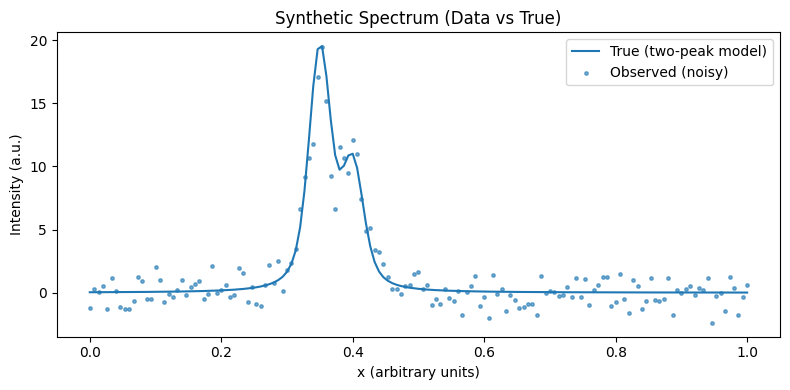

In [ ]:
# --- Example 1: Synthetic data generation (heteroskedastic noise) ---
# Creates (x, y_true, y_obs, sigma_i) for downstream fitting
# Noise model: sigma_i = sqrt(sigma0**2 + (alpha * y_true)**2)

import numpy as np
from scipy.special import wofz  # for Voigt
import matplotlib.pyplot as plt

rng = np.random.default_rng(seed=41)  # reproducible

def voigt_profile(x, amplitude, center, gamma, sigma):
    """
    Voigt profile: amplitude * Re[ w(z) ] / (sigma * sqrt(2*pi))
    where w(z) = exp(-z^2) * erfc(-i z), z = (x + i*gamma) / (sigma*sqrt(2))
    Reference: scipy.special.wofz
    """
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2.0))
    return amplitude * np.real(wofz(z)) / (sigma * np.sqrt(2.0 * np.pi))

# --- 1) x-grid ---
x = np.linspace(0.0, 1.0, 151)  # high enough density to show overlap

# --- 2) True two-peak model (shared width) ---
# Choose nearby centers; shared gamma, sigma to reduce degeneracy in later fits
A1, A2 = 1.00, 0.50
c1, c2 = 0.35, 0.40            # close peaks to create a shoulder
gamma_shared = 0.01           # Lorentzian HWHM
sigma_shared = 0.012           # Gaussian sigma

y1 = voigt_profile(x, A1, c1, gamma_shared, sigma_shared)
y2 = voigt_profile(x, A2, c2, gamma_shared, sigma_shared)
y_true = y1 + y2

# --- 3) Heteroskedastic noise parameters ---
alpha = 0.2    # fractional noise level (e.g., photon statistics ~ 8%)
sigma0 = 1.0   # baseline readout floor

sigma_i = np.sqrt(sigma0**2 + (alpha * y_true)**2)

# --- 4) Generate noisy observations ---
noise = rng.normal(loc=0.0, scale=sigma_i)
y_obs = y_true + noise

# --- 5) Pack for downstream use ---
# We'll reuse x, y_true, y_obs, sigma_i in later cells (M0 and M1 fits, diagnostics, etc.)
print(f"x.shape={x.shape}, y_obs.shape={y_obs.shape}, y_true.shape={y_true.shape}, sigma_i.shape={sigma_i.shape}")
print(f"Noise summary: alpha={alpha:.3f}, sigma0={sigma0:.3f}, "
      f"mean(sigma_i)={sigma_i.mean():.4f}, min={sigma_i.min():.4f}, max={sigma_i.max():.4f}")

# (Optional) quick sanity plot; we'll produce formal plots with residual subplots later
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(x, y_true, label="True (two-peak model)")
ax.scatter(x, y_obs, s=6, label="Observed (noisy)", alpha=0.6)
ax.set_xlabel("x (arbitrary units)")
ax.set_ylabel("Intensity (a.u.)")
ax.set_title("Synthetic Spectrum (Data vs True)")
ax.legend()

plt.tight_layout()
plt.show()

# Stage 1 Single Peak Fit

## Stage 1 — Fit a single-peak model \(M_0\) and inspect residuals

-   Fit a **single Voigt** model $M_0$ with weighted least squares using $1/\sigma_i^2$.
-   Determine adequacy is with the **residuals** $r_i = y_i^{\mathrm{obs}} - \hat{y}_i$.

If the single-peak hypothesis is wrong, residuals often show coherent structure (e.g., alternating positive/negative bias) near the shoulder, not random scatter.

The single-peak model fitted is given by:

$$
\hat{y}(x) = A \cdot \mathrm{Voigt}(x; c, \gamma, \sigma) + b_0
$$

where $A$ is the amplitude, $c$ is the center, $\gamma$ is the Lorentzian width (HWHM), $\sigma$ is the Gaussian width, and $b_0$ is a constant baseline.

**The code cell below:**
-   implements a Voigt profile by computing the Faddeeva function,
-   fits $M_0$ via weighted LS,
-   computes $r_i$ and weighted $\chi^2(M_0)=\sum r_i^2/\sigma_i^2$,
-   plots (top) data + fit and (bottom) residuals.

## Comments
In model fitting with weighted least squares, $\chi^2$ is a measure of the discrepancy between your observed data and your model's prediction, scaled by the expected noise.

$$ \chi^2(M) = \sum_{i=1}^{N} \frac{\bigl(y_i^{\mathrm{obs}} - \hat{y}_i(M)\bigr)^2}{\sigma_i^2} $$

Goodness of Fit: A lower $\chi^2$ value indicates that the model $\hat{y}_i(M)$ is a better fit to the observed data $y_i^{\mathrm{obs}}$, given the expected noise $\sigma_i$.

## Single peak fit (just the lower peak) for comparison of chi squared

Single peak data generated: y_obs_single.shape=(151,), sigma_i_single.shape=(151,)

=== Single-peak fit (M0) to Single-peak data summary ===
     A =  1.00915 ± 0.0852
     c =  0.348617 ± 0.00163
 gamma =  0.0170262 ± 0.00396
 sigma =  0.00658392 ± 0.00731
    b0 = -0.145725 ± 0.101
chi2       = 123.205
dof        = 146
chi2_red   = 0.844


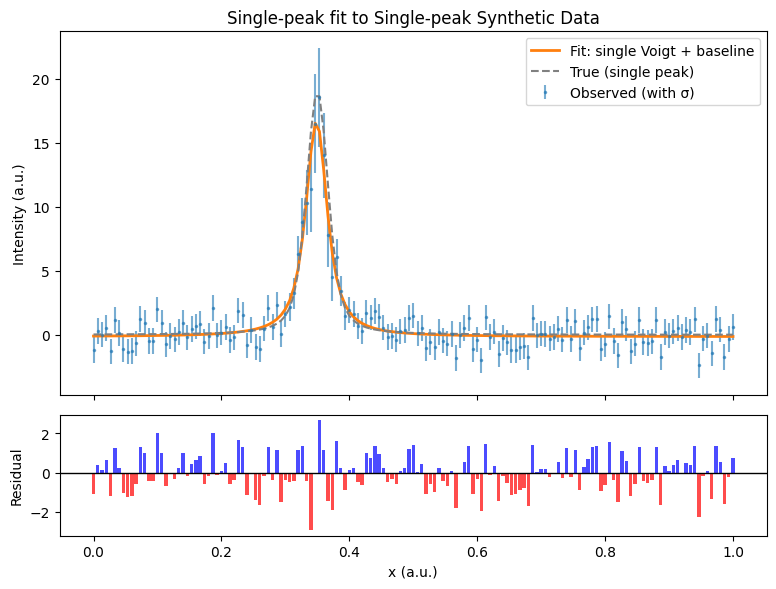

In [ ]:
# --- Example 1: Single Peak Synthetic data generation ---
# Creates (x, y_true_single, y_obs_single, sigma_i_single) for single peak fitting

import numpy as np
from scipy.special import wofz  # for Voigt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

rng = np.random.default_rng(seed=41)  # reproducible

def voigt_profile(x, amplitude, center, gamma, sigma):
    """
    Voigt profile: amplitude * Re[ w(z) ] / (sigma * sqrt(2*pi))
    where w(z) = exp(-z^2) * erfc(-i z), z = (x + i*gamma) / (sigma*sqrt(2))
    Reference: scipy.special.wofz
    """
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2.0))
    return amplitude * np.real(wofz(z)) / (sigma * np.sqrt(2.0 * np.pi))

def single_peak_model(x, A, c, gamma, sigma, b0):
    """Single Voigt peak + constant baseline."""
    return b0 + voigt_profile(x, A, c, gamma, sigma)


# --- Reuse x-grid and parameters from the original two-peak setup ---
# (Assuming x, A1, c1, gamma_shared, sigma_shared are available from a previous cell)
try:
    x, A1, c1, gamma_shared, sigma_shared = x, A1, c1, gamma_shared, sigma_shared
except NameError:
    print("Warning: Could not find original parameters. Using defaults.")
    x = np.linspace(0.0, 1.0, 151)
    A1, c1 = 1.00, 0.35
    gamma_shared = 0.01
    sigma_shared = 0.012


# --- 1) True single-peak model ---
y_true_single = voigt_profile(x, A1, c1, gamma_shared, sigma_shared)


# --- 2) Heteroskedastic noise parameters (reuse original alpha, sigma0 if available) ---
try:
    alpha, sigma0 = alpha, sigma0
except NameError:
    print("Warning: Could not find original noise parameters. Using defaults.")
    alpha = 0.2
    sigma0 = 1

sigma_i_single = np.sqrt(sigma0**2 + (alpha * y_true_single)**2)

# --- 3) Generate noisy observations for the single peak ---
noise_single = rng.normal(loc=0.0, scale=sigma_i_single)
y_obs_single = y_true_single + noise_single

print(f"Single peak data generated: y_obs_single.shape={y_obs_single.shape}, sigma_i_single.shape={sigma_i_single.shape}")


# --- 4) Fit a single-peak model (M0) to the single-peak data ---

# ---- Initial guesses (robust, simple heuristics) ----
# Center near maximum observed intensity
c0_single = x[np.argmax(y_obs_single)]
# Baseline from lower decile (robust to peaks)
b0_guess_single = np.percentile(y_obs_single, 10)
# Amplitude roughly peak height above baseline
A0_single = max(y_obs_single.max() - b0_guess_single, 1e-3)
# Width guesses (safe small positive numbers)
gamma0_single = 0.010
sigma0_guess_single = 0.012

p0_single = [A0_single, c0_single, gamma0_single, sigma0_guess_single, b0_guess_single]

# Bounds: keep widths positive and reasonable; allow center within data range
lower_single = [0.0, x.min(), 1e-5, 1e-5, -np.inf]
upper_single = [np.inf, x.max(), 0.2, 0.2,  np.inf]

# ---- Weighted non-linear least squares ----
popt_single, pcov_single = curve_fit(
    single_peak_model, x, y_obs_single,
    p0=p0_single, bounds=(lower_single, upper_single),
    sigma=sigma_i_single, absolute_sigma=True, maxfev=20000
)

# Parameter names and uncertainties
param_names_single = ["A", "c", "gamma", "sigma", "b0"]
perr_single = np.sqrt(np.diag(pcov_single))

# Fitted curve and residuals
y_fit_single = single_peak_model(x, *popt_single)
res_single = y_obs_single - y_fit_single

# Weighted chi-squared and reduced chi-squared
chi2_single = np.sum((res_single / sigma_i_single)**2)
k_single = len(popt_single)   # number of parameters
N_single = len(x)
dof_single = max(N_single - k_single, 1)
chi2_red_single = chi2_single / dof_single

# ---- Print a concise fit summary ----
print("\n=== Single-peak fit (M0) to Single-peak data summary ===")
for name, val, err in zip(param_names_single, popt_single, perr_single):
    print(f"{name:>6s} = {val: .6g} ± {err:.3g}")
print(f"chi2       = {chi2_single:.3f}")
print(f"dof        = {dof_single:d}")
print(f"chi2_red   = {chi2_red_single:.3f}")


# --- 5) Plot: data+fit (top) & residuals (bottom) ---
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, sharex=True, figsize=(8, 6),
    gridspec_kw={"height_ratios": [3, 1]}
)

# Top: observed data with optional errorbars and fitted curve
ax_top.errorbar(x, y_obs_single, yerr=sigma_i_single, fmt='.', ms=3, alpha=0.6, label="Observed (with σ)")
ax_top.plot(x, y_fit_single, lw=2, label="Fit: single Voigt + baseline")
ax_top.plot(x, y_true_single, '--', color='gray', label="True (single peak)") # Add true single peak for comparison
ax_top.set_ylabel("Intensity (a.u.)")
ax_top.set_title("Single-peak fit to Single-peak Synthetic Data")
ax_top.legend(loc="best")

# Bottom: residuals with zero line
ax_bot.axhline(0.0, color='k', lw=1)
# Plotting residuals as bars
ax_bot.bar(x, res_single, width=(x[1]-x[0])*0.8, color=['blue' if r > 0 else 'red' for r in res_single], alpha=0.7)
ax_bot.set_xlabel("x (a.u.)")
ax_bot.set_ylabel("Residual")

plt.tight_layout()
plt.show()

### When to use $\chi^2$ and Reduced $\chi^2$ for Goodness of Fit

You can use $\chi^2$ as a measure of the goodness of fit primarily when your data have **known and independent Gaussian uncertainties** $\sigma_i$. The formula for $\chi^2$ is:

$$
\chi^2 = \sum_{i=1}^{N} \frac{(y_i^{\mathrm{obs}} - \hat{y}_i)^2}{\sigma_i^2}
$$

This is appropriate for data where the noise follows a normal distribution and the uncertainty of each data point is known *a priori* (e.g., from calibration or fundamental processes like Poisson statistics in photon counting). This applies well to many types of experimental data in physics, astronomy, and other sciences.

The **reduced $\chi^2$** is simply $\chi^2$ divided by the degrees of freedom ($\nu = N - k$, where $N$ is the number of data points and $k$ is the number of fitted parameters):

$$
\chi^2_{\nu} = \frac{\chi^2}{\nu}
$$

You use $\chi^2$ to get the raw sum of squared, weighted residuals, which is the quantity minimized in weighted least squares. You use **reduced $\chi^2$** to assess the *quality* of the fit. If the model is correct and the uncertainties $\sigma_i$ are accurately known, the expected value of the reduced $\chi^2$ is approximately 1. A value significantly greater than 1 suggests the model is poor or the uncertainties are underestimated. A value significantly less than 1 might indicate overestimated uncertainties or that the model is fitting noise.

An **independent $\chi^2$ random variable** refers to the statistical distribution that the $\chi^2$ statistic follows *if* the model is correct and the data errors are independent, Gaussian, and have known variances. Specifically, if you have $\nu$ independent standard normal random variables $Z_i \sim \mathcal{N}(0, 1)$, their sum of squares $\sum_{i=1}^{\nu} Z_i^2$ follows a $\chi^2$ distribution with $\nu$ degrees of freedom, denoted $\chi^2(\nu)$. When fitting a model with $k$ parameters to $N$ data points with known Gaussian errors, the $\chi^2$ statistic for a correct model is expected to follow a $\chi^2(N-k)$ distribution. This is why we compare our observed $\Delta\chi^2$ to a $\chi^2(\Delta df)$ distribution in the likelihood-ratio test for nested models.

## Single-peak fit to two-peak spectrum

=== Single-peak fit (M0) summary ===
     A =  1.32791 ± 0.124
     c =  0.370373 ± 0.00219
 gamma =  0.00584019 ± 0.00877
 sigma =  0.0364161 ± 0.0058
    b0 = -0.094104 ± 0.122
chi2       = 138.247
dof        = 146
chi2_red   = 0.947


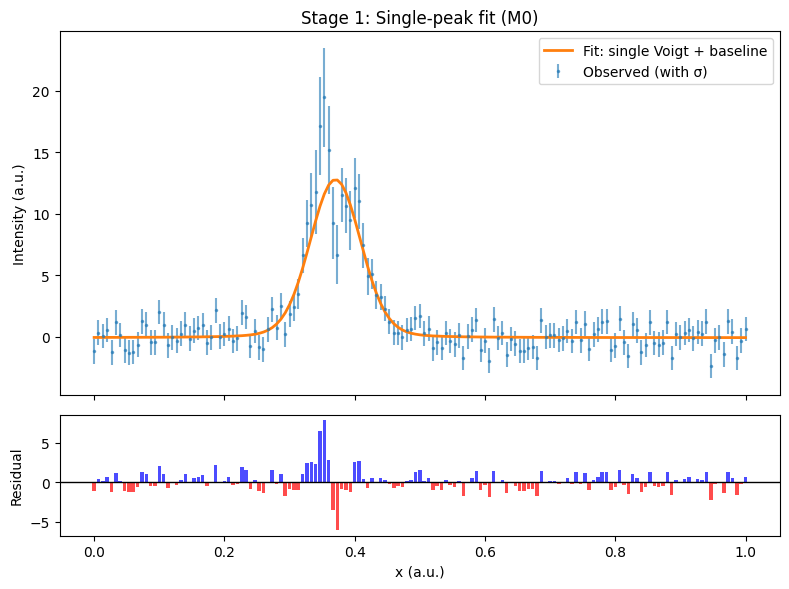

In [ ]:
# --- Example 1: Stage 1 — Single-peak fit (M0) with weighted least squares ---
# Requirements (from previous cell):
# - x, y_obs, sigma_i  (arrays)
# - voigt_profile(x, amplitude, center, gamma, sigma)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def single_peak_model(x, A, c, gamma, sigma, b0):
    """Single Voigt peak + constant baseline."""
    return b0 + voigt_profile(x, A, c, gamma, sigma)

# ---- Initial guesses (robust, simple heuristics) ----
# Center near maximum observed intensity
c0 = x[np.argmax(y_obs)]
# Baseline from lower decile (robust to peaks)
b0_guess = np.percentile(y_obs, 10)
# Amplitude roughly peak height above baseline
A0 = max(y_obs.max() - b0_guess, 1e-3)
# Width guesses (safe small positive numbers)
gamma0 = 0.010
sigma0_guess = 0.012

p0 = [A0, c0, gamma0, sigma0_guess, b0_guess]

# Bounds: keep widths positive and reasonable; allow center within data range
lower = [0.0, x.min(), 1e-5, 1e-5, -np.inf]
upper = [np.inf, x.max(), 0.2, 0.2,  np.inf]

# ---- Weighted non-linear least squares ----
# curve_fit with sigma and absolute_sigma=True -> chi^2 = sum((resid/sigma)^2)
popt, pcov = curve_fit(
    single_peak_model, x, y_obs,
    p0=p0, bounds=(lower, upper),
    sigma=sigma_i, absolute_sigma=True, maxfev=20000
)

# Parameter names and uncertainties
param_names = ["A", "c", "gamma", "sigma", "b0"]
perr = np.sqrt(np.diag(pcov))

# Fitted curve and residuals
y_fit_M0 = single_peak_model(x, *popt)
res_M0 = y_obs - y_fit_M0

# Weighted chi-squared and reduced chi-squared
chi2_M0 = np.sum((res_M0 / sigma_i)**2)
k0 = len(popt)   # number of parameters
N = len(x)
dof0 = max(N - k0, 1)
chi2_red_M0 = chi2_M0 / dof0

# ---- Print a concise fit summary ----
print("=== Single-peak fit (M0) summary ===")
for name, val, err in zip(param_names, popt, perr):
    print(f"{name:>6s} = {val: .6g} ± {err:.3g}")
print(f"chi2       = {chi2_M0:.3f}")
print(f"dof        = {dof0:d}")
print(f"chi2_red   = {chi2_red_M0:.3f}")

# ---- Plot: data+fit (top) & residuals (bottom) ----
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, sharex=True, figsize=(8, 6),
    gridspec_kw={"height_ratios": [3, 1]}
)

# Top: observed data with optional errorbars and fitted curve
ax_top.errorbar(x, y_obs, yerr=sigma_i, fmt='.', ms=3, alpha=0.6, label="Observed (with σ)")
ax_top.plot(x, y_fit_M0, lw=2, label="Fit: single Voigt + baseline")
ax_top.set_ylabel("Intensity (a.u.)")
ax_top.set_title("Stage 1: Single-peak fit (M0)")
ax_top.legend(loc="best")

# Bottom: residuals with zero line
ax_bot.axhline(0.0, color='k', lw=1)
# Plotting residuals as bars
ax_bot.bar(x, res_M0, width=(x[1]-x[0])*0.8, color=['blue' if r > 0 else 'red' for r in res_M0], alpha=0.7)
ax_bot.set_xlabel("x (a.u.)")
ax_bot.set_ylabel("Residual")

plt.tight_layout()
plt.show()

# Stage 2

## Stage 2 — Fit a two-peak model \(M_1\) and inspect residuals

Now fit a **double Voigt** $M_1$ with a **shared width** to reduce degeneracy; amplitudes and centers are independent. If a second peak is warranted, residuals should lose the shoulder signature and look noise-like relative to $\sigma_i$. Mirror the plotting format from Stage 1 (main panel + residuals subplot) to enable a fair, visual-statistical comparison.

**Code cell below** to:
- fits $M_1$ via weighted LS,
- computes residuals and $\chi^2(M_1)$,
- plots (top) data + two-peak fit and (bottom) residuals.

=== Two-peak fit (M1) summary ===
    A1 =  0.922868 ± 0.106
    c1 =  0.34769 ± 0.00232
    A2 =  0.594343 ± 0.0725
    c2 =  0.40049 ± 0.00274
 gamma =  0.0146202 ± 0.00401
 sigma =  0.0100832 ± 0.00463
    b0 = -0.16234 ± 0.108
chi2       = 121.491
dof        = 144
chi2_red   = 0.844


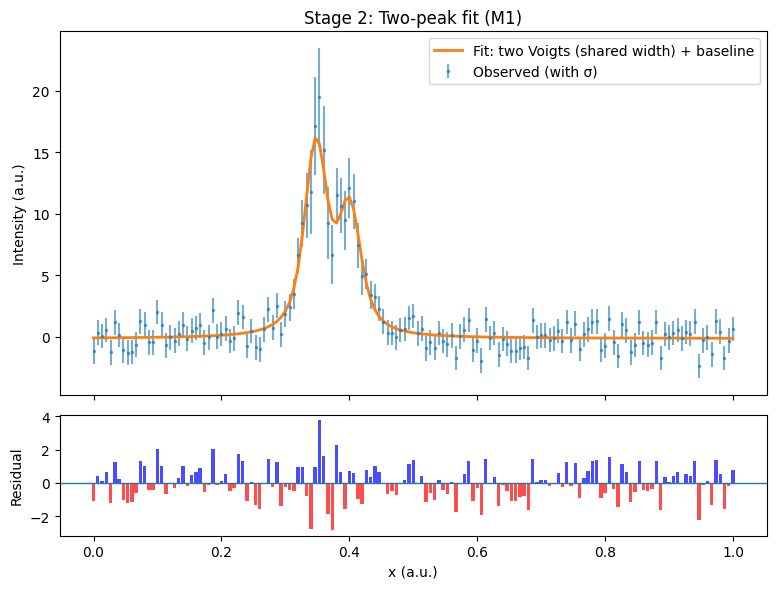

In [ ]:
# --- Example 1: Stage 2 — Two-peak fit (M1) with shared width (weighted LS) ---
# Requirements:
# - x, y_obs, sigma_i
# - voigt_profile(...)
# - From Stage 1: we can use M0 results to seed initial guesses

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def two_peak_model_shared_width(x, A1, c1, A2, c2, gamma, sigma, b0):
    """Sum of two Voigt peaks (shared gamma, sigma) + constant baseline."""
    y = b0
    y += voigt_profile(x, A1, c1, gamma, sigma)
    y += voigt_profile(x, A2, c2, gamma, sigma)
    return y

# --- Initial guesses ---
# Use M0 center to seed nearby centers; keep shared widths close to M0 widths if available
try:
    # If M0 results exist in the namespace
    A_M0, c_M0, gamma_M0, sigma_M0, b0_M0 = popt
    b0_guess = float(b0_M0)
    gamma0 = max(float(gamma_M0), 1e-4)
    sigma0 = max(float(sigma_M0), 1e-4)
    # Split centers around M0 center by a small offset
    dc = 0.02 * (x.max() - x.min())  # small offset proportional to range
    c1_0 = np.clip(c_M0 - dc, x.min(), x.max())
    c2_0 = np.clip(c_M0 + dc, x.min(), x.max())
    # Split amplitude
    A_total = max(float(A_M0), 1e-3)
    A1_0 = 0.6 * A_total
    A2_0 = 0.4 * A_total
except NameError:
    # Fallback if M0 not run (shouldn't happen in this workflow)
    b0_guess = np.percentile(y_obs, 10)
    A_total = max(y_obs.max() - b0_guess, 1e-3)
    A1_0, A2_0 = 0.6 * A_total, 0.4 * A_total
    # Guess centers from data quantiles
    c1_0 = np.quantile(x, 0.45)
    c2_0 = np.quantile(x, 0.55)
    gamma0 = 0.010
    sigma0 = 0.012

p0_M1 = [A1_0, c1_0, A2_0, c2_0, gamma0, sigma0, b0_guess]

# Bounds: amplitudes >= 0; centers within data range; widths positive but reasonable
lower_M1 = [0.0, x.min(), 0.0, x.min(), 1e-5, 1e-5, -np.inf]
upper_M1 = [np.inf, x.max(), np.inf, x.max(), 0.2, 0.2,  np.inf]

# --- Weighted non-linear least squares for M1 ---
popt_M1, pcov_M1 = curve_fit(
    two_peak_model_shared_width, x, y_obs,
    p0=p0_M1, bounds=(lower_M1, upper_M1),
    sigma=sigma_i, absolute_sigma=True, maxfev=40000
)

param_names_M1 = ["A1", "c1", "A2", "c2", "gamma", "sigma", "b0"]
perr_M1 = np.sqrt(np.diag(pcov_M1))

# Fitted curve and residuals
y_fit_M1 = two_peak_model_shared_width(x, *popt_M1)
res_M1 = y_obs - y_fit_M1

# Weighted chi-squared and reduced chi-squared
chi2_M1 = np.sum((res_M1 / sigma_i)**2)
k1 = len(popt_M1)
N = len(x)
dof1 = max(N - k1, 1)
chi2_red_M1 = chi2_M1 / dof1

# --- Print a concise fit summary ---
print("=== Two-peak fit (M1) summary ===")
for name, val, err in zip(param_names_M1, popt_M1, perr_M1):
    print(f"{name:>6s} = {val: .6g} ± {err:.3g}")
print(f"chi2       = {chi2_M1:.3f}")
print(f"dof        = {dof1:d}")
print(f"chi2_red   = {chi2_red_M1:.3f}")

# --- Plot: data+fit (top) & residuals (bottom) ---
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, sharex=True, figsize=(8, 6),
    gridspec_kw={"height_ratios": [3, 1]}
)

# Top: observed data with errorbars and fitted curve
ax_top.errorbar(x, y_obs, yerr=sigma_i, fmt='.', ms=3, alpha=0.6, label="Observed (with σ)")
ax_top.plot(x, y_fit_M1, lw=2, label="Fit: two Voigts (shared width) + baseline")
ax_top.set_ylabel("Intensity (a.u.)")
ax_top.set_title("Stage 2: Two-peak fit (M1)")
ax_top.legend(loc="best")

# Bottom: residuals with zero line
ax_bot.axhline(0.0, lw=1)
# Plotting residuals as bars
ax_bot.bar(x, res_M1, width=(x[1]-x[0])*0.8, color=['blue' if r > 0 else 'red' for r in res_M1], alpha=0.7)
ax_bot.set_xlabel("x (a.u.)")
ax_bot.set_ylabel("Residual")

plt.tight_layout()
plt.show()

# Stage 3 — Quantitative comparison: $\Delta\chi^2$ and AIC

## Stage 3 — Quantitative model comparison: nested models, $\Delta\chi^2$, and AIC

Now that we have fits for both the **single-peak** model $M_0$ and the **two-peak** model $M_1$, we want to determine whether the additional complexity in $M_1$ is statistically justified.

---

### What is a *nested* model?

A model $M_1$ is said to be **nested** within a simpler model $M_0$ if you can recover the simpler model by **fixing** or **removing** parameters in the more complex one. In other words:

> You can obtain $M_0$ by turning off pieces of $M_1$.

In this example:
- $M_1$ reduces to $M_0$ if the **second peak’s amplitude** is set to zero (and its center becomes irrelevant).
- Therefore, the simpler model lies *inside* the parameterization of the more complex model.

Nestedness matters because it allows us to use the **likelihood-ratio test** ($\Delta\chi^2$).

---

### Count the parameters to determine the degrees of freedom penalty

The **single-peak** model $M_0$ fits:
- amplitude $A$
- center $c$
- Lorentzian width $\gamma$
- Gaussian width $\sigma$
- constant baseline $b_0$

so:
$$
k_0 = 5
$$

The **two-peak** model $M_1$ (with shared widths) fits:
- amplitudes $A_1, A_2$
- centers $c_1, c_2$
- shared $\gamma$
- shared $\sigma$
- baseline $b_0$

so:
$$
k_1 = 7
$$

Therefore, the additional number of fitted parameters is:

$$
\Delta df = k_1 - k_0 = 2
$$

This is the number of degrees of freedom used in the $\Delta\chi^2$ significance test.

---

### Compute weighted chi-squared

Because we modeled heteroskedastic noise via $\sigma_i$, we evaluate the **weighted** chi-square:

$$
\chi^2(M) = \sum_{i=1}^{N} \frac{\bigl(y_i^{\mathrm{obs}} - \hat{y}_i(M)\bigr)^2}{\sigma_i^2}
$$

We compute this quantity for both $M_0$ and $M_1$.

---

### Likelihood-ratio statistic ($\Delta\chi^2$)

To test whether the additional peak significantly improves the fit, we compute:

$$
\Delta \chi^2 = \chi^2(M_0) - \chi^2(M_1)
$$

A **large positive** value indicates that the more complex model explains the data substantially better than noise alone would predict.

Because the models are nested, and because the **form** of the variance was specified, $\Delta\chi^2$ follows a chi-square distribution with $\Delta df = 2$ degrees of freedom. We compute a $p$-value from this distribution.

- If $p < 0.05$: the improvement is **unlikely** to be due to random noise → statistical evidence for a second peak.
- If $p > 0.05$: we cannot rule out that the improvement came from noise → no statistical justification for splitting.

---


### Residual literacy

Visual overlays alone are not reliable. Instead, we inspect **residuals**:

- Does $M_1$ whiten the structured shoulder region?
- Do residuals under $M_0$ show clear oscillatory patterns?
- Are residuals consistent with the known $\sigma_i$?

If the shoulder structure disappears under $M_1$, that’s strong physical evidence.

---



## Computing p-values

### How do we compute the $p$-value?

Once we compute the difference in weighted chi-squared values

$$
\Delta \chi^2 = \chi^2(M_0) - \chi^2(M_1),
$$

we compare this improvement to what would be expected **by chance** if the simpler model $M_0$ were actually correct. Because $M_1$ is a nested extension of $M_0$ that adds $\Delta df$ additional parameters (two, in our case), statistical theory tells us that $\Delta\chi^2$ approximately follows a chi-square distribution with $\Delta df$ degrees of freedom:

$$
\Delta\chi^2 \sim \chi^2(\Delta df).
$$

The **$p$-value** answers the question:

> If the *simpler* model $M_0$ were true, how likely would it be to see an improvement in $\chi^2$ **at least this large** just by random noise?

Mathematically, the $p$-value is the **survival function** (right-tail probability) of the chi-square distribution:

$$
p = P(\chi^2 \ge \Delta\chi^2 \mid \Delta df).
$$

In Python (with SciPy), this is computed as:

```python
from scipy.stats import chi2
p_value = chi2.sf(delta_chi2, ddf)
```

where:

- `delta_chi2` is the observed improvement,
- `ddf` is the difference in number of fitted parameters ($k_1 - k_0 = 2$ here),
- `sf` means *survival function* (1 minus the cumulative distribution function).

---

### How do we interpret the $p$-value?

- **Small $p$** (e.g., $p < 0.05$):  
  It would be *unlikely* for random noise alone to produce such a large improvement.  
  ⇒ Evidence that the added peak helps describe real structure in the data.

- **Large $p$** (e.g., $p > 0.05$):  
  Improvements of this size happen *routinely* due to noise.  
  ⇒ No statistical justification for adding the second peak.

---

### Why the right tail?

We are interested in the probability of seeing an improvement **as large or larger**, not smaller, than what we observed. That is why we compute the **area to the right** of $\Delta\chi^2$ under the chi-square curve.

Graphically:

```
|-----------------------------|--------------|
0                          Δχ²           → tail →  p-value
```

That shaded right-hand tail tells us how surprising our observed improvement would be **if** $M_0$ were true.

---

### Summary

- Compute $\Delta\chi^2$ from the two fitted models.
- Determine $\Delta df = k_1 - k_0$.
- Evaluate the right-tail probability of $\Delta\chi^2$ under $\chi^2(\Delta df)$.
- A small $p$ indicates that adding the second peak yields a statistically meaningful improvement.


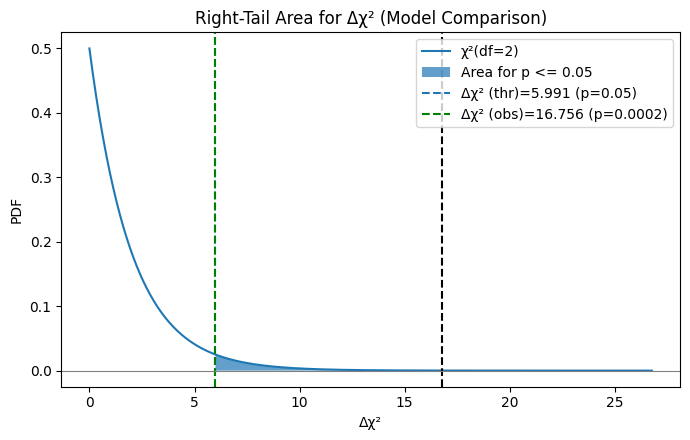

Δχ²-observed = 16.756, right-tail p = 0.0002
Δχ² threshold for p=0.05 = 5.991


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

def shade_right_tail(ax, x, pdf_vals, x0, alpha=0.05):
    """Shade the right-tail area x >= x0 under the given curve."""
    mask = x >= x0
    ax.fill_between(x[mask], pdf_vals[mask], 0.0, alpha=alpha)
    ax.axvline(x0, linestyle="--")

# Parameters for the chi-squared plot for model comparison
nu_model_comp = 2  # Degrees of freedom for delta chi-squared
chi2_obs_model_comp = 16.756  # Observed delta chi-squared
alpha_model_comp = 0.05

# Calculate the delta chi-squared threshold for alpha = 0.05
delta_chi2_threshold = chi2.isf(alpha_model_comp, df=nu_model_comp)

# Domain for the chi-squared plot
# We need a range that includes the observed chi-squared value and extends into the tail
x_model_comp = np.linspace(0, chi2_obs_model_comp + 10, 1000) # Adjust range as needed

pdf_chi2_model_comp = chi2.pdf(x_model_comp, df=nu_model_comp)
p_chi2_model_comp = chi2.sf(chi2_obs_model_comp, df=nu_model_comp)

fig, ax = plt.subplots(figsize=(7, 4.5))
ax.plot(x_model_comp, pdf_chi2_model_comp, label=f"χ²(df={nu_model_comp})")
# Shade the area to the right of the threshold
shade_right_tail(ax, x_model_comp, pdf_chi2_model_comp, delta_chi2_threshold, alpha=0.7) # Increased alpha for darker shading

# Add the vertical line for the delta chi-squared threshold
ax.axvline(delta_chi2_threshold, linestyle="--", color='green', label=f"Δχ² (thr)={delta_chi2_threshold:.3f} (p=0.05)")

# Add the vertical line for the observed delta chi-squared
ax.axvline(chi2_obs_model_comp, linestyle="--", color='black', label=f"Δχ² (obs)={chi2_obs_model_comp:.3f} (p={p_chi2_model_comp:.4f})")


# Add a grey line at y=0
ax.axhline(0, color='grey', linewidth=0.8)

ax.set_xlabel("Δχ²")
ax.set_ylabel("PDF")
ax.set_title("Right-Tail Area for Δχ² (Model Comparison)")
# Update the legend to include the threshold line and observed chi-squared
ax.legend([f"χ²(df={nu_model_comp})", f"Area for p <= {alpha_model_comp}", f"Δχ² (thr)={delta_chi2_threshold:.3f} (p=0.05)", f"Δχ² (obs)={chi2_obs_model_comp:.3f} (p={p_chi2_model_comp:.4f})"])
plt.tight_layout()
plt.show()

print(f"Δχ²-observed = {chi2_obs_model_comp:.3f}, right-tail p = {p_chi2_model_comp:.4f}")
print(f"Δχ² threshold for p=0.05 = {delta_chi2_threshold:.3f}")

## Akaike Information Criterion (AIC)

Even if $p < 0.05$, we still ask whether the improvement is justified given that we have added parameters; adding parameters will improve the visible fit by reducing residuals, but may lead to overfitting. To address this issue, we will use the Akaike Information Criterion (AIC):

$$
\mathrm{AIC} = 2k + \chi^2
$$

where $k$ is the number of parameters and $\chi^2$ is the minimized weighted chi-squared value. AIC balances goodness of fit ($\chi^2$) with model complexity ($2k$).

To compare two models, we calculate the difference in their AIC values. When comparing a more complex model $M_1$ (with $k_1$ parameters) to a simpler model $M_0$ (with $k_0$ parameters), the difference is typically calculated as:

$$
\Delta \mathrm{AIC} = \mathrm{AIC}(M_1) - \mathrm{AIC}(M_0)
$$

Since $k_1 > k_0$, the more complex model $M_1$ starts with a penalty ($2k_1$) that is larger than the simpler model's penalty ($2k_0$). Therefore:

-   If $\Delta \mathrm{AIC}$ is **negative**, the reduction in $\chi^2$ achieved by the more complex model $M_1$ is large enough to overcome its larger parameter penalty. This favors the **more complex model ($M_1$)**.
-   If $\Delta \mathrm{AIC}$ is **positive**, the reduction in $\chi^2$ in $M_1$ was not enough to justify the additional parameters. This favors the **simpler model ($M_0$)**.

The magnitude of $|\Delta \mathrm{AIC}|$ indicates the strength of evidence for the favored model. Rules of thumb for interpretation:

-   $|\Delta\mathrm{AIC}| < 2$: negligible evidence for one model over the other.
-   $2 \le |\Delta\mathrm{AIC}| \le 7$: moderate evidence for the favored model.
-   $|\Delta\mathrm{AIC}| > 7$ (some sources use 10): strong evidence for the favored model.

In our case, we are comparing $M_1$ (two peaks) to $M_0$ (single peak), so $\Delta \mathrm{AIC} = \mathrm{AIC}(M_1) - \mathrm{AIC}(M_0)$. A **negative** $\Delta$AIC provides evidence for adding the second peak ($M_1$).

In [ ]:
# --- Example 1: Stage 3 — Model comparison (Δχ², p-value, AIC) ---
# Requires from previous cells:
# - chi2_M0, chi2_M1  (weighted chi-squared, i.e., sum((res/sigma_i)**2))
# - k0, k1            (number of free params in each model)
# - N                 (number of data points)
# - Optional: dof0, dof1 (for reference)

import numpy as np
from scipy.stats import chi2

# Sanity checks
assert 'chi2_M0' in globals() and 'chi2_M1' in globals(), "Missing chi-squared values from prior fits."
assert 'k0' in globals() and 'k1' in globals(), "Missing parameter counts k0/k1."
assert 'N' in globals(), "Missing N (data length)."

# Degrees of freedom difference for nested models
ddf = int(k1 - k0)
if ddf <= 0:
    raise ValueError(f"Expected k1>k0 for nested models. Got k0={k0}, k1={k1}.")

# Δχ² and p-value (likelihood-ratio test)
delta_chi2 = chi2_M0 - chi2_M1
p_value = chi2.sf(delta_chi2, ddf)  # survival function = 1-CDF

# AIC for each model
AIC_M0 = 2 * k0 + chi2_M0
AIC_M1 = 2 * k1 + chi2_M1
delta_AIC = AIC_M1 - AIC_M0  # negative favors M1

# Nicely formatted summary
print("=== Model Comparison Summary (M0: single peak, M1: two peaks) ===")
print(f"N               = {N}")
print(f"k0, k1          = {k0}, {k1}   (Δdf = {ddf})")
print(f"chi2(M0)        = {chi2_M0:.3f}")
print(f"chi2(M1)        = {chi2_M1:.3f}")
print(f"Δchi2           = {delta_chi2:.3f}")
print(f"p-value (Δdf={ddf}) = {p_value:.3g}")
print(f"AIC(M0)         = {AIC_M0:.3f}")
print(f"AIC(M1)         = {AIC_M1:.3f}")
print(f"ΔAIC (M1-M0)    = {delta_AIC:.3f}   [negative favors M1]")

# Decision guidance
alpha = 0.05
sig_text = "significant" if p_value < alpha else "not significant"
aic_text = (
    "negligible (<2)" if abs(delta_AIC) < 2 else
    "moderate (4–7)"  if 2 <= abs(delta_AIC) <= 7 else
    "strong (>10)"
)

print("\n--- Decision Guide ---")
print(f"Likelihood-ratio (Δχ²) result: {sig_text} at α={alpha}.")
if delta_AIC < 0:
    print(f"AIC favors M1 (two peaks) with {aic_text} evidence.")
elif delta_AIC > 0:
    print(f"AIC favors M0 (single peak) with {aic_text} evidence.")
else:
    print("AIC tie (ΔAIC ≈ 0).")

# Optional: one-line verdict template
if (p_value < alpha) and (delta_AIC < -2):
    print("\nVerdict: Two-peak model (M1) is statistically justified and preferred by AIC.")
elif (p_value >= alpha) and (delta_AIC > 2):
    print("\nVerdict: Single-peak model (M0) is not rejected and is preferred by AIC.")
else:
    print("\nVerdict: Mixed signals — report both tests and discuss residuals/physics.")


=== Model Comparison Summary (M0: single peak, M1: two peaks) ===
N               = 151
k0, k1          = 5, 7   (Δdf = 2)
chi2(M0)        = 138.247
chi2(M1)        = 121.491
Δchi2           = 16.756
p-value (Δdf=2) = 0.00023
AIC(M0)         = 148.247
AIC(M1)         = 135.491
ΔAIC (M1-M0)    = -12.756   [negative favors M1]

--- Decision Guide ---
Likelihood-ratio (Δχ²) result: significant at α=0.05.
AIC favors M1 (two peaks) with strong (>10) evidence.

Verdict: Two-peak model (M1) is statistically justified and preferred by AIC.


### Putting it all together

To justify two peaks over a single peak, we ideally want:

1.  **$\Delta\chi^2$** significant (reject $M_0$ in favor of $M_1$). This means a small p-value (typically < 0.05).
2.  **AIC** favoring $M_1$ (reward improvement despite complexity). Since $\Delta \mathrm{AIC} = \mathrm{AIC}(M_1) - \mathrm{AIC}(M_0)$, this corresponds to a **negative** $\Delta$AIC value. The magnitude of this negative value indicates the strength of evidence.
3.  **Residuals**: systematic structure disappears in the residuals of $M_1$ compared to $M_0$, and the residuals of $M_1$ look consistent with the expected noise.

When these criteria align, we have stronger confidence that the data support the more complex two-peak model.

# Stage 4: Residual diagnostics

## **Residual diagnostics**: standardized residuals, histograms, and QQ-plots

After fitting both models, we now shift our focus from “how well does the curve overlay the data?” to **where and how** the models fail. These patterns often reveal whether a missing physical effect (such as a second peak) remains in the data. Visual overlays alone can hide systematic differences, so residual analysis is a critical scientific practice.

---

### What are residuals?

A **residual** is the difference between what we observed and what a model predicts at each point:

$$
r_i = y_i^{\mathrm{obs}} - \hat{y}_i
$$

If a model captures all of the meaningful structure in the data, the residuals should behave like random noise centered around zero.

---

### Why *standardize* residuals?

Our noise model assigns a different expected uncertainty $\sigma_i$ to each point (because points with higher intensity have slightly higher noise). To compare residuals fairly across the entire dataset, we divide each residual by its expected standard deviation:

$$
z_i = \frac{r_i}{\sigma_i}
$$

These **standardized residuals** should, if the model is appropriate, look like random draws from a **standard normal distribution** (mean 0, standard deviation 1).

---

### What to look for in the histogram

We will plot histograms of the standardized residuals for both models. If the model is capturing the structure:

- The histogram should be roughly symmetric around zero.
- Most values should fall within $-2 \le z \le 2$.
- There should be no clear excess of outliers.

If the histogram is noticeably **skewed**, **broadened**, or has **long tails**, then the model may be missing an underlying feature of the data.

---

### Spatial patterns in residual plots

When we plot standardized residuals versus $x$:

- If the model is appropriate, the residuals should fluctuate randomly above and below zero.
- If you see **waves**, **shoulders**, or consistent positive/negative regions, that suggests that the model failed to capture some part of the spectral shape.

In this example, a single-peak model often leaves a **systematic oscillation** near the shoulder region. A two-peak model should reduce that pattern substantially if a true second feature exists.

---

### What is a QQ-plot, and how do we read it?

A **quantile–quantile (QQ)** plot compares the distribution of standardized residuals to a theoretical **standard normal distribution**. It asks:

> Are the residuals shaped like we would expect from random noise?

How to read it:

- The dashed line represents *perfect* agreement with the standard normal.
- If the points fall **along the line**, the residuals are consistent with random noise.
- If the points curve **above** the line at the ends, the residuals have **heavy tails** (unexpected large deviations).
- If the points fall **below and above** near the center, the distribution may be **too narrow or skewed**.
- A subtle “S-shape” can indicate that the model is systematically over- or under-estimating values in different intensity regions.

QQ-plots are especially powerful because they reveal differences the histogram alone may hide.

---

### What should we expect in this example?

For the **single-peak** model $M_0$:

- Residuals near the shoulder region may show a **structured** pattern.
- The histogram may appear slightly broadened.
- The QQ-plot may deviate from the line at the tails.

For the **two-peak** model $M_1$:

- These structured patterns should diminish.
- The histogram should look more symmetric.
- Points in the QQ-plot should fall closer to the line.

Importantly, “closer” does not mean perfect. We are looking for **noticeable improvement**, not perfection.

---

### Why does this matter scientifically?

Residual diagnostics tell us **where** and **how** our model is failing. If both $\Delta\chi^2$ and AIC suggest adding a second peak, residual patterns can help us confirm that the improvement is meaningful rather than accidental.

A model must not only provide a better numerical score; it must also leave behind noise-like differences when compared to the data.

In short:

- Standardized residuals quantify whether the model respects the noise model.
- Histograms show whether the deviations behave like expected fluctuations.
- QQ-plots reveal whether the distribution shape matches our assumptions.

When these diagnostics agree with the statistical tests from Stage 3, we gain confidence that the additional peak represents real structure rather than chance.

---

### Common pitfalls when interpreting residual diagnostics

Students frequently make the following mistakes during model assessment:

**1. Treating small differences in visual overlays as decisive.**  
Two curves can look nearly identical on a plot while leaving very different patterns in the residuals. Never skip the residuals.

**2. Ignoring the data region where residuals are largest.**  
Residuals in low-intensity regions are expected to be noisier; what matters is whether the model consistently overshoots or undershoots in *specific* spectral regions (like a shoulder).

**3. Forgetting that standardized residuals are *scaled* by uncertainty.**  
A value of $z=3$ is unusual *even if* the absolute deviation looks small. Standardization normalizes perspective.

**4. Interpreting a lack of obvious structure as “proof” of correctness.**  
Residuals will always contain randomness; the absence of clear failure does not guarantee that a simpler model is physically correct.

**5. Overreacting to a few extreme outliers.**  
One or two points beyond $z=\pm 3$ can happen by chance, especially with tens or hundreds of data points. Look for *patterns*, not isolated surprises.

**6. Confusing histogram “bumps” with meaningful structure.**  
Histogram appearance depends on binning. If you see a suspicious shape, corroborate with the QQ-plot.

**7. Misreading QQ-plot curvature.**  
A gentle bow does not imply failure. What matters is whether the curvature indicates systematic deviation from the assumed noise distribution — especially near the shoulders.

**8. Over-interpreting the plot center.**  
The center of a QQ-plot is always most crowded and should not dominate the decision. Pay attention to the tails.

---

### A cartoon analogy for QQ-plots

Imagine lining up students in order of height and having them stand next to cardboard cutouts representing the expected heights from a normal population:

- If each student matches their cutout, the line is straight: the data are normally distributed.
- If the real students are consistently taller at the ends, the line curves upward: heavier tails than normal.
- If students in the middle bunch up while ends diverge, the line makes an “S” shape: too peaked in the center, too many outliers at the edges.
- If the whole line tilts, the mean is biased (systematic over- or under-prediction).

This analogy works because the QQ-plot literally aligns **quantiles** (rank-ordered values) in the data against **quantiles** of a reference distribution. Deviations show where the population of residuals grows differently than expected.

---

### Bottom line

Residual diagnostics are not about perfection. They are about spotting:
- unresolved structure,
- systematic shifts,
- distribution mismatches,

that reveal what our *model* is failing to describe, not what the *data* are doing wrong.


=== M0 (single-peak) standardized residuals ===
mean(z) = +0.0213
std(z)  = 0.9598
skew    = -0.0660
kurtosis(excess) = -0.4812

=== M1 (two-peak) standardized residuals ===
mean(z) = +0.0000
std(z)  = 0.9000
skew    = +0.0020
kurtosis(excess) = -0.5635



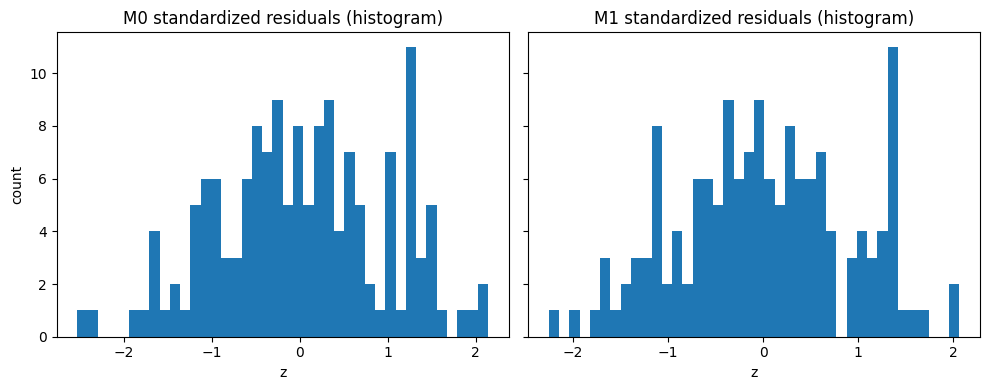

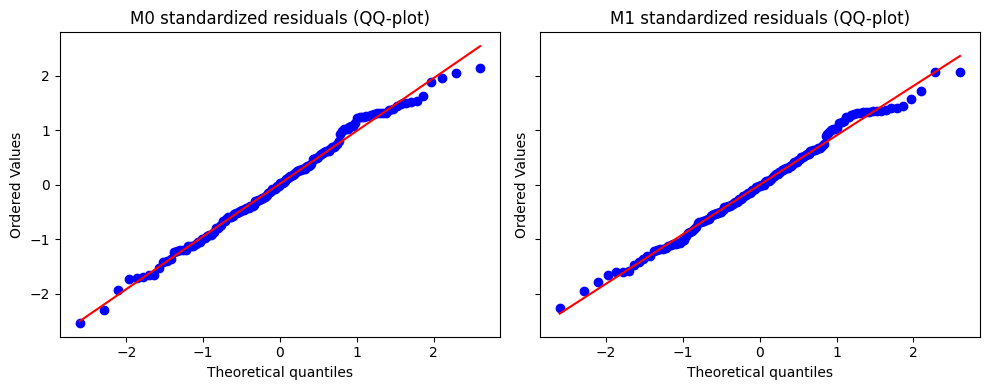

In [ ]:
# --- Example 1: Stage 4 — Residual diagnostics (standardized residuals, hist, QQ) ---
# Requires:
# - res_M0, res_M1, sigma_i from prior cells

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Standardized residuals
z_M0 = res_M0 / sigma_i
z_M1 = res_M1 / sigma_i

def summarize(name, z):
    print(f"=== {name} standardized residuals ===")
    print(f"mean(z) = {np.mean(z):+.4f}")
    print(f"std(z)  = {np.std(z, ddof=1):.4f}")
    print(f"skew    = {stats.skew(z):+.4f}")
    print(f"kurtosis(excess) = {stats.kurtosis(z):+.4f}")
    print()

summarize("M0 (single-peak)", z_M0)
summarize("M1 (two-peak)",   z_M1)

# 1) Histograms
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].hist(z_M0, bins=40)
axes[0].set_title("M0 standardized residuals (histogram)")
axes[0].set_xlabel("z")
axes[0].set_ylabel("count")

axes[1].hist(z_M1, bins=40)
axes[1].set_title("M1 standardized residuals (histogram)")
axes[1].set_xlabel("z")

plt.tight_layout()
plt.show()

# 2) QQ-plots against standard normal
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
stats.probplot(z_M0, dist="norm", plot=axes[0])
axes[0].set_title("M0 standardized residuals (QQ-plot)")

stats.probplot(z_M1, dist="norm", plot=axes[1])
axes[1].set_title("M1 standardized residuals (QQ-plot)")

plt.tight_layout()
plt.show()


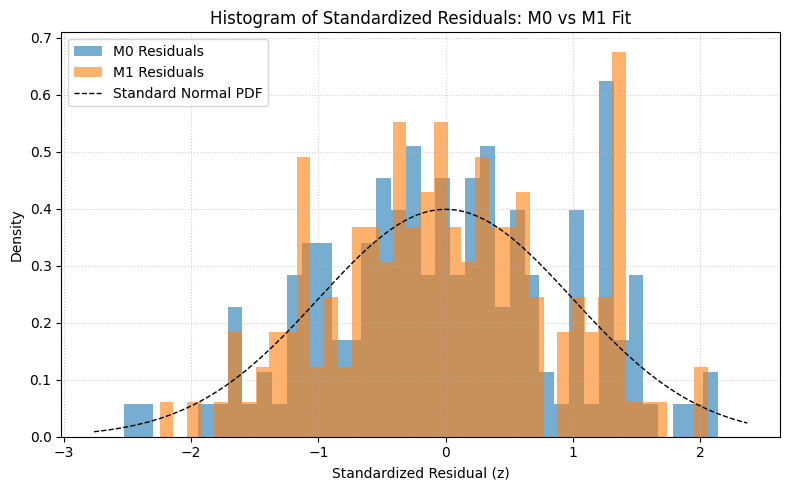

In [ ]:
# --- Example 1: Stage 4 — Combined Residual Plot (Histogram) ---
# Requires:
# - z_M0, z_M1 (standardized residuals from O0n3xIZzaNLa)

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Ensure variables are available
try:
    z_M0, z_M1
except NameError:
    print("Error: Required variables (z_M0, z_M1) not found. Please run previous cells.")
    # Optionally, add placeholder data or exit
    # z_M0 = np.random.randn(100)
    # z_M1 = np.random.randn(100)
    # exit()

fig, ax = plt.subplots(figsize=(8, 5))

# Plot histograms of standardized residuals
ax.hist(z_M0, bins=40, density=True, alpha=0.6, label='M0 Residuals', color='C0')
ax.hist(z_M1, bins=40, density=True, alpha=0.6, label='M1 Residuals', color='C1')

# Optional: Plot a standard normal PDF for reference
xmin, xmax = ax.get_xlim()
x_plot = np.linspace(xmin, xmax, 100)
pdf = norm.pdf(x_plot, 0, 1)
ax.plot(x_plot, pdf, 'k--', lw=1, label='Standard Normal PDF')


ax.set_xlabel("Standardized Residual (z)")
ax.set_ylabel("Density") # Use density if density=True in hist
ax.set_title("Histogram of Standardized Residuals: M0 vs M1 Fit")
ax.legend()
ax.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

## Stage 5 — Known vs estimated variance; sensitivity to noise assumptions

Because we **specified** $\alpha$ and $\sigma_0$ in the simulation, using $\chi^2$ for comparison is appropriate. In real measurements, $\alpha$ and $\sigma_0$ are uncertain; labs estimate them from calibrations or residuals. Test robustness by slightly varying $\alpha$ and/or $\sigma_0$ and re-fitting. If conclusions (significance of $\Delta\chi^2$, and AIC preference) flip under small, plausible changes, the “two peaks” claim is fragile; if results are stable, your inference is stronger.

In the simulation, $\alpha$ represents the **fractional noise level** associated with signal-dependent noise, often related to photon counting statistics in techniques like Raman scattering. This noise source typically scales with the square root of the signal intensity ($\sqrt{y_i}$), which becomes proportional to $\alpha y_i$ in the variance $(\alpha y_i)^2$. $\sigma_0$ represents the **baseline noise floor**, independent of the signal intensity. In Raman scattering, this can correspond to detector readout noise, dark current, or other background sources that contribute a constant level of noise across the spectrum, regardless of the peak intensity. Together, $\alpha$ and $\sigma_0$ capture common sources of heteroskedastic noise observed in such experiments.

**The code cell below**:
-   sweeps a small grid of $(\alpha,\sigma_0)$,
-   re-fits $M_0, M_1$ (few iterations per point),
-   maps where $M_1$ is significant **and** preferred by AIC.

Fraction of (alpha, sigma0) grid favoring M1 by both criteria: 0.800


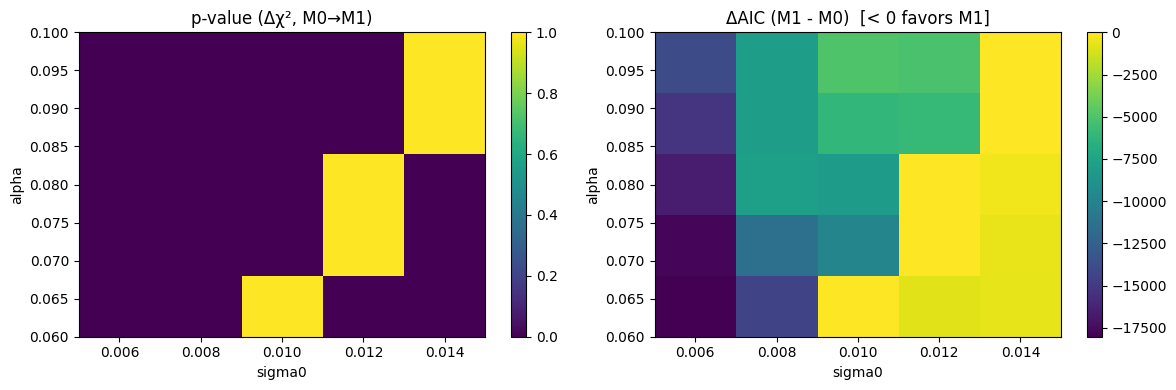

In [ ]:
# --- Example 1: Stage 5 — Sensitivity to noise assumptions (alpha, sigma0) ---
# Requires:
# - x, y_obs, y_true, voigt_profile
# - single_peak_model, two_peak_model_shared_width
# - curve_fit imported earlier
# - Optionally: M0 parameter results for seeding; otherwise fallback heuristics are used

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2

# Preserve original fitted parameter vectors for seeding (if available)
seed_M0 = None
try:
    seed_M0 = popt.copy()
except Exception:
    pass

def fit_M0_with_sigma(sigma_w):
    """Fit single-peak model using provided sigma_w (weights). Returns (chi2, k, popt)."""
    # Initial guess strategy (reuse prior M0 if available; else recompute heuristics)
    if seed_M0 is not None:
        p0 = seed_M0
    else:
        c0 = x[np.argmax(y_obs)]
        b0_guess = np.percentile(y_obs, 10)
        A0 = max(y_obs.max() - b0_guess, 1e-3)
        p0 = [A0, c0, 0.010, 0.012, b0_guess]
    lower = [0.0, x.min(), 1e-5, 1e-5, -np.inf]
    upper = [np.inf, x.max(), 0.2,   0.2,   np.inf]
    popt_loc, pcov_loc = curve_fit(
        single_peak_model, x, y_obs, p0=p0, bounds=(lower, upper),
        sigma=sigma_w, absolute_sigma=True, maxfev=20000
    )
    yfit = single_peak_model(x, *popt_loc)
    res = y_obs - yfit
    chi2_val = np.sum((res / sigma_w)**2)
    k = len(popt_loc)
    return chi2_val, k, popt_loc

def fit_M1_with_sigma(sigma_w, seed_from_M0=None):
    """Fit two-peak shared-width model using provided sigma_w (weights). Returns (chi2, k, popt)."""
    # Seed strategy: derive from M0 if provided; else heuristic
    if seed_from_M0 is not None:
        A_M0, c_M0, gamma_M0, sigma_M0, b0_M0 = seed_from_M0
        b0_guess = float(b0_M0)
        gamma0 = max(float(gamma_M0), 1e-4)
        sigma0 = max(float(sigma_M0), 1e-4)
        dc = 0.02 * (x.max() - x.min())
        c1_0 = np.clip(c_M0 - dc, x.min(), x.max())
        c2_0 = np.clip(c_M0 + dc, x.min(), x.max())
        A_total = max(float(A_M0), 1e-3)
        A1_0, A2_0 = 0.6 * A_total, 0.4 * A_total
    else:
        b0_guess = np.percentile(y_obs, 10)
        A_total = max(y_obs.max() - b0_guess, 1e-3)
        A1_0, A2_0 = 0.6 * A_total, 0.4 * A_total
        c1_0 = np.quantile(x, 0.45)
        c2_0 = np.quantile(x, 0.55)
        gamma0, sigma0 = 0.010, 0.012

    p0_M1 = [A1_0, c1_0, A2_0, c2_0, gamma0, sigma0, b0_guess]
    lower_M1 = [0.0, x.min(), 0.0, x.min(), 1e-5, 1e-5, -np.inf]
    upper_M1 = [np.inf, x.max(), np.inf, x.max(), 0.2,   0.2,   np.inf]

    popt_loc, pcov_loc = curve_fit(
        two_peak_model_shared_width, x, y_obs, p0=p0_M1,
        bounds=(lower_M1, upper_M1),
        sigma=sigma_w, absolute_sigma=True, maxfev=30000
    )
    yfit = two_peak_model_shared_width(x, *popt_loc)
    res = y_obs - yfit
    chi2_val = np.sum((res / sigma_w)**2)
    k = len(popt_loc)
    return chi2_val, k, popt_loc

# Define a modest grid around the original alpha, sigma0
alpha_center = 0.08
sigma0_center = 0.01
alpha_vals = np.linspace(alpha_center * 0.75, alpha_center * 1.25, 5)
sigma0_vals = np.linspace(sigma0_center * 0.5, sigma0_center * 1.5, 5)

# Containers for results
pval_map = np.full((len(alpha_vals), len(sigma0_vals)), np.nan)
dAIC_map = np.full_like(pval_map, np.nan, dtype=float)
favor_M1 = np.zeros_like(pval_map, dtype=bool)

N = len(x)

for i, a in enumerate(alpha_vals):
    for j, s0 in enumerate(sigma0_vals):
        # Recompute weights from the same y_true but different noise params
        sigma_grid = np.sqrt(s0**2 + (a * y_true)**2)

        # Fit M0, then use its params to seed M1
        try:
            chi2_0, k0_g, popt0_g = fit_M0_with_sigma(sigma_grid)
            chi2_1, k1_g, popt1_g = fit_M1_with_sigma(sigma_grid, seed_from_M0=popt0_g)
        except Exception as e:
            # If a fit fails, leave NaNs and continue
            print(f"[warn] Fit failed at alpha={a:.4f}, sigma0={s0:.4f}: {e}")
            continue

        ddf = k1_g - k0_g
        delta_chi2 = chi2_0 - chi2_1
        pval = chi2.sf(delta_chi2, ddf)

        AIC0 = 2*k0_g + chi2_0
        AIC1 = 2*k1_g + chi2_1
        dAIC = AIC1 - AIC0  # negative favors M1

        pval_map[i, j] = pval
        dAIC_map[i, j] = dAIC
        favor_M1[i, j] = (pval < 0.05) and (dAIC < -2)

# Summary metric: fraction of grid where M1 is supported by both tests
valid_mask = np.isfinite(pval_map) & np.isfinite(dAIC_map)
support_fraction = np.mean(favor_M1[valid_mask]) if np.any(valid_mask) else np.nan
print(f"Fraction of (alpha, sigma0) grid favoring M1 by both criteria: {support_fraction:.3f}")

# Simple visualizations: heatmaps of p-value and ΔAIC
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
im0 = axes[0].imshow(pval_map, origin='lower', aspect='auto',
                     extent=[sigma0_vals[0], sigma0_vals[-1], alpha_vals[0], alpha_vals[-1]])
axes[0].set_title("p-value (Δχ², M0→M1)")
axes[0].set_xlabel("sigma0")
axes[0].set_ylabel("alpha")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(dAIC_map, origin='lower', aspect='auto',
                     extent=[sigma0_vals[0], sigma0_vals[-1], alpha_vals[0], alpha_vals[-1]])
axes[1].set_title("ΔAIC (M1 - M0)  [< 0 favors M1]")
axes[1].set_xlabel("sigma0")
axes[1].set_ylabel("alpha")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


## Decision & interpretation templates

**Split justified.**\
“The improvement is significant, $\Delta\chi^2 = X$ (p < 0.05, $\Delta df = 2$), and parsimony favors the two-peak model ($\Delta$AIC = Z). Residuals lose the shoulder pattern and match the variance model. We interpret the feature as two overlapping modes.”

**Split not justified.**\
“The improvement is not significant (p > 0.05) and $\Delta$AIC < 2. Residuals are structureless under the single-peak fit. We do **not** claim evidence for splitting given the current resolution and noise.”

In [ ]:
# --- Example 1: Compact Verdict Helper ---
# Requires from previous cells:
# - chi2_M0, chi2_M1, delta_chi2, p_value, delta_AIC, ddf
# - alpha threshold assumed 0.05

alpha = 0.05

def verdict_helper(p_value, delta_AIC, alpha=0.05):
    """
    Provide succinct, one-paragraph verdict phrased in scientific language.
    """
    print("=== Compact Verdict Helper ===")

    # Default neutral template
    text = []

    # Significance test outcome
    if p_value < alpha:
        text.append(f"The improvement from M0 to M1 is statistically significant (p = {p_value:.3g}).")
    else:
        text.append(f"The improvement from M0 to M1 is not statistically significant (p = {p_value:.3g}).")

    # AIC preference
    if delta_AIC < -2:
        text.append(f"AIC favors M1 (ΔAIC = {delta_AIC:.3f}).")
    elif delta_AIC > 2:
        text.append(f"AIC favors M0 (ΔAIC = {delta_AIC:.3f}).")
    else:
        text.append(f"AIC does not clearly distinguish the models (ΔAIC = {delta_AIC:.3f}).")

    # Combined verdict logic
    if (p_value < alpha) and (delta_AIC < -2):
        text.append("Together, these tests support the interpretation of two partially overlapping peaks.")
    elif (p_value >= alpha) and (delta_AIC > 2):
        text.append("Together, these tests support treating the feature as a single broadened peak.")
    else:
        text.append("The tests disagree; inspect residuals and physical plausibility before concluding.")

    # Final print
    print(" ".join(text))

# Run it
verdict_helper(p_value, delta_AIC, alpha)


=== Compact Verdict Helper ===
The improvement from M0 to M1 is statistically significant (p = 0.00023). AIC favors M1 (ΔAIC = -12.756). Together, these tests support the interpretation of two partially overlapping peaks.
